# Setting and computing descriptors

In this notebook, we will take a look at some of the available descriptors to learn how to parametrize them, and add filters to them to compute partial correlations or to restrict the analysis to a given subset of particles.

<div class="alert alert-warning">
    Important
    
    Check out [this tutorial](../descriptors/overview.html) for an overview of the available structural descriptors, as well as the detailed presentations of each individual descriptor under **Tutorials** » **Structural descriptors** in the documentation.
</div>

## Structural descriptors

A structural descriptor $S$ is a collection of $N$ individual empirical distributions or feature vectors, $\{s_i(\vec{x})\}$, defined over a grid $\{x_j\}$ of $M$ features. 

$$
S = \begin{pmatrix}
s_0(x_0) & s_0(x_1) & ... & s_0(x_M) \\
s_1(x_0) & s_1(x_1) & ... & s_1(x_M) \\ 
...      & ...      & ... & ... \\
s_N(x_0) & s_N(x_1) & ... & s_N(x_M)
\end{pmatrix}
$$

Each structural descriptor inherits from a base class `StructuralDescriptor`, which stores the data matrix $S$ as an attribute called `features` of type `numpy.ndarray`. The features can be computed between two arbitrary subsets of particles called “*groups*”:

- **group 0** is the main group, *i.e.* particles for which the structural features are being computed.
- **group 1** is the secondary group, *i.e.* particles that are being considered when computing the structural features.

These groups are formed by adding **filters** on particle properties (*e.g.* species, radius, position, etc.). For instance, in order to compute a given partial correlation function $C_{\alpha\beta}(x)$ between two chemical species $(\alpha, \beta)$, one would add a first filter on group 0 to select only type-$\alpha$ particles, and a second filter on group 1 to select only type-$\beta$ particles. This will be discussed further in the rest of this notebook.

The base class `StructuralDescriptor` has the following properties and attributes, shared by all the descriptors:

* `trajectory`: a descriptor is defined for a given `Trajectory` (see [this notebook](1_trajectory.html) to learn more about trajectories).
* `dimension`: the spatial dimension of the descriptor. Indeed, some descriptors can only be computed for 2D or 3D trajectories.
* `grid`: grid of features over which the structural features will be computed. For instance, the values of interparticle distances $r$ (*i.e.* bins) when using a radial descriptor.
* `active_filters`: list of all the active filters on both groups prior to the computation of the descriptor.
* `features`: array of all the structural structural features for particles in the main group (*i.e.* group 0). This attribute is `None` by default and is set only when the the descriptor is computed, upon calling the `compute()` method (see example below).
* `n_features`: number of features $M$ of the descriptor.
* `n_samples`: total number of particles considered to compute the descriptor (*i.e.* number of particles in group 0).
* `average`: average feature vector of the descriptor, $\langle s \rangle = (1/N) \sum_i s_i(\vec{x})$.
* `groups`: composition of the groups: `groups[0]` and `groups[1]` contain lists of all the `Particle` instances in groups 0 and 1 respectively.
* `verbose`: show progress information and warnings about the computation of the descriptor when this attribute is `True`, and remain silent when it is `False`.
* `accept_nans`: if `False`, discard any row from the array of features that contains a *NaN* element. If `True`, keep *NaN* elements in the array of features.
* `neighbors_boost`: scaling factor to estimate the number of neighbors relative to a an ideal gas with the same density. This is used internally to set the dimensions of lists of neighbors. A too small number creates a risk of overfilling the lists of neighbors, and a too large number increases memory usage.
* `max_num_neighbors`: maximum number of neighbors. This is used internally to set the dimensions of lists of neighbors. This number is automatically adjusted to limit memory usage if the associated `Trajectory` has valid cutoffs in the `Trajectory.nearest_neighbors_cutoffs` list attribute.

These attributes and properties will be detailed in the rest of this notebook. We start by creating an abstract `StructuralDescriptor` a on a trajectory file to illustrate some of them:

In [1]:
from partycls import Trajectory
from partycls.descriptors import StructuralDescriptor

# Open a trajectory
traj = Trajectory('../data/kalj_N150.xyz', last=20)

# Create a descriptor
D = StructuralDescriptor(traj)

<div class="alert alert-info">
    Note
    
    We emphasize that the class `StructuralDescriptor` is **abstract** and does not perform any computation. This is only an example to show the common properties of the subclasses. Actual examples will be shown later in this notebook.
</div>

By default, all particles are included in groups 0 and 1. The composition of these groups is accessible through the attribute `groups`, a tuple with two elements:

- `groups[0]` is the list of particles in the main group (group 0)
- `groups[1]` the particles in the secondary group (group 1)

In [2]:
# A tuple with two elements
print(len(D.groups))

2


Each element of this tuple is a list whose length is equal to the number of frames in the trajectory:

In [3]:
# Number of frames in the trajectory
print('Number of frames in the trajectory:', len(traj))

# Length of the groups
print('Length of the groups:', len(D.groups[0]), len(D.groups[1]))

Number of frames in the trajectory: 21
Length of the groups: 21 21


Each of these sublists contains all the particles that belong to the group:

In [4]:
# The first 3 particles in the first frame of group 0
print("A few particles in the first frame of group 0:")
for i in range(3):
    print(D.groups[0][0][i])

# All particles are in both groups by default.
# Number of particles in the groups of the first frame
print('\nGroup sizes (first frame) :', len(D.groups[0][0]), len(D.groups[1][0]))

A few particles in the first frame of group 0:
Particle(position=[ 0.819926 -1.760086  0.36845 ], species=A, label=-1, radius=0.5, nearest_neighbors=None, species_id=1)
Particle(position=[ 0.29098   1.24579  -2.495344], species=A, label=-1, radius=0.5, nearest_neighbors=None, species_id=1)
Particle(position=[2.484607 0.35245  1.371003], species=A, label=-1, radius=0.5, nearest_neighbors=None, species_id=1)

Group sizes (first frame) : 150 150


The total group sizes, trajectory-wide, can be accessed with the `group_size()` method:

In [5]:
print('Group sizes (total) :', D.group_size(0), D.group_size(1))

Group sizes (total) : 3150 3150


### Filters

To restrict the computation of the descriptor to a given subset, we can apply a filter with the method `add_filter()`. This is done by specifying the filter with a string of the form:

`"particle.<attribute> _operator_ <value>"`

or simply

`"<attribute> _operator_ <value>"`

for common attributes, *e.g.* `"species == 'A'"` or `"particle.radius < 0.5"`.

The group onto which the filter is applied must also be specified.

The current input trajectory file is a binary mixture of particles labeled `"A"` and `"B"` with chemical fractions of 0.8 and 0.2 respectively. Let us restrict the computation of the structural features to type-B particles only:

In [6]:
# Add a filter on group 0
D.add_filter("species == 'B'", group=0)

# Active filters
print("Active filters:", D.active_filters)

Active filters: [("particle.species == 'B'", 0)]


Group 0 now contains only B particles, and group 1 still contains all the particles:

In [7]:
# Group sizes in the first frame
print('Size of group 0 :', len(D.groups[0][0]), '(first frame)')
print('Size of group 1 :', len(D.groups[1][0]), '(first frame)')

# Group sizes over all frames
print('\nSize of group 0 :', D.group_size(0), '(total)')
print('Size of group 1 :', D.group_size(1), '(total)')

# Fractions of particles in the groups
#  (over the whole trajectory)
print('\nGroup 0 fraction :', D.group_fraction(0), '(total)')
print('Group 1 fraction :', D.group_fraction(1), '(total)')

Size of group 0 : 30 (first frame)
Size of group 1 : 150 (first frame)

Size of group 0 : 630 (total)
Size of group 1 : 3150 (total)

Group 0 fraction : 0.2 (total)
Group 1 fraction : 1.0 (total)


This means that the features will be computed for type-B particles only, but by considering all particles (both type-A and type-B). Now, let us make this a partial correlation by focusing the analysis on A particles:

In [8]:
D.add_filter("species == 'A'", group=1)
print("Active filters:", D.active_filters)

# New fractions
print('\nGroup #0 fraction :', D.group_fraction(0))
print('Group #1 fraction :', D.group_fraction(1))

Active filters: [("particle.species == 'B'", 0), ("particle.species == 'A'", 1)]

Group #0 fraction : 0.2
Group #1 fraction : 0.8


<div class="alert alert-warning">
    Important
    
    More than one filter can be applied to the same group. Filters can be cumulated, as long as there are particles left in the corresponding group. 
</div>


Filters can be removed with the methods `clear_filters()` (clears all filters on the specified group) and `clear_all_filters()` (clears all filters on both groups):

In [9]:
# Remove filter on group #0
D.clear_filters(0)
print('Group 0 fraction:', D.group_fraction(0))

# Remove all filters (both groups #0 and #1)
D.clear_all_filters()
print('Group 1 fraction:', D.group_fraction(1))

Group 0 fraction: 1.0
Group 1 fraction: 1.0


All particles are included again in both groups.

### Accessing a group property

Much like the method `Trajectory.get_property` (see [this notebook](1_trajectory.html)), the properties of the particles in each group can be accessed through the method `get_group_property()` (also called `dump()` for short):

In [10]:
# Species of the particles in group #0
species = D.get_group_property('species', group=0)
# 10 first particles in the first frame
print(species[0][0:10])

# Keep only B particles in group #0
D.add_filter("species == 'B'")
# 10 first particles in the first frame
species = D.get_group_property('species', group=0)
print(species[0][0:10])

['A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A']
['B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B']


A few more examples:

In [11]:
# Positions of particles in group #0
pos_0 = D.dump('pos', 0)

# Radii of particles in group #1
rad_1 = D.dump('radius', 1)

# Position x of particles in group #0
x_0 = D.dump('x', 0)

<div class="alert alert-info">
    Note

    Unlike `Trajectory.get_property()`, this method only applies to particles. Moreover, it **does not** accept a `subset` parameter.
</div>

Mastering the notion of *groups* (*i.e.* their internal structure and all their attributes) is not essential to use the code. This is only useful for specific usage, as will become clear with the rest of this notebook and the next.
    
In order to compute the structural features, the method `compute()` must be called. This will set the `features` attribute. Let us move on to more practical examples with some of the structural descriptors available in the code.

<div class="alert alert-warning">
    Important
    
    For a more detailed presentation of each descriptor, check out the tutorials under **Tutorials** » **Structural descriptors** in the documentation.
</div>
    
## Practical example 1 - The radial descriptor

The class `RadialDescriptor` computes the radial correlations of a central particle with all its surrounding particles within the range of distances $(r_\mathrm{min}, r_\mathrm{max})$. For a given particle $i$, it computes a histogram that counts the particles between $r$ and $r + \Delta r$ between the specified range. See the [dedicated tutorial](../descriptors/gr.html).

We create a radial descriptor and set the `verbose` attribute to `True` to show the progression:

In [12]:
from partycls.descriptors import RadialDescriptor

# Open a trajectory
traj = Trajectory('../data/kalj_N150.xyz', last=20)

# Radial descriptor between r=0 and r=2 with bin size dr=0.1
D_r = RadialDescriptor(traj, bounds=(0,2), dr=0.1, verbose=True)

# Grid
print('Grid of distances:\n', D_r.grid)

Grid of distances:
 [0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35
 1.45 1.55 1.65 1.75 1.85 1.95]


We compute the descriptor:

In [13]:
# Compute the features (this also sets D_r.features)
X_r = D_r.compute()

Computing gr descriptor: 100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 1145.37it/s]


The variable `X_r` contains all the structural features, and can also be accessed through the attribute `features`.

The average of the descriptor is the average over all histograms:

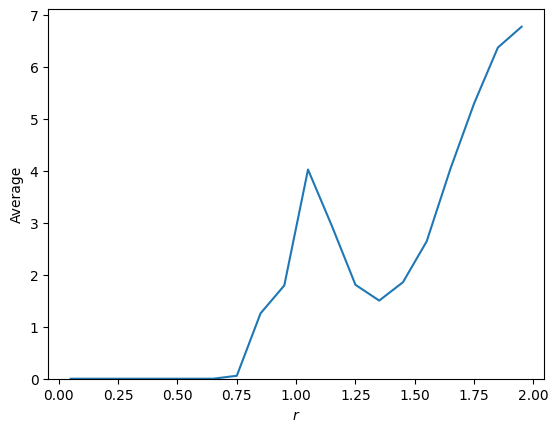

In [14]:
import matplotlib.pyplot as plt

# Plot the average descriptor
plt.plot(D_r.grid, D_r.average)
plt.xlabel(r"$r$")
plt.ylabel("Average")
plt.ylim(bottom=0)
plt.show()

Another example with filters:

In [15]:
# A-A correlation
D_r_AA = RadialDescriptor(traj, bounds=(0,2), dr=0.1)
D_r_AA.add_filter("species == 'A'", 0)
D_r_AA.add_filter("species == 'A'", 1)
_ = D_r_AA.compute()

# A-B correlation
D_r_AB = RadialDescriptor(traj, bounds=(0,2), dr=0.1)
D_r_AB.add_filter("species == 'A'", 0)
D_r_AB.add_filter("species == 'B'", 1)
_ = D_r_AB.compute()

Let us normalize the distributions in order to get true $g(r)$.

As mentioned in the [notebook on worflows](2_workflow.html), the class `RadialDescriptor` implements a normalization function that allows for two types of normalization through a `method` parameter:

* `method='r2'` returns $r^2g(r)$ (default) ;
* `method='gr'` returns the standard $g(r)$ ;

In our case, we are interested in standard $g(r)$ and $g_{\alpha\beta}(r)$:

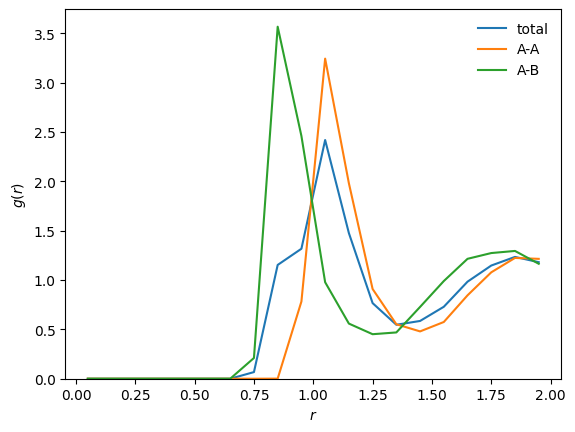

In [16]:
# /!\ Normalization depends on the descriptor in this case
g    = D_r.normalize(D_r.average, method='gr')
g_AA = D_r_AA.normalize(D_r_AA.average, method='gr')
g_AB = D_r_AB.normalize(D_r_AB.average, method='gr')

# Plot
plt.plot(D_r.grid, g, label='total')
plt.plot(D_r_AA.grid, g_AA, label='A-A')
plt.plot(D_r_AB.grid, g_AB, label='A-B')
plt.xlabel(r"$r$")
plt.ylabel(r"$g(r)$")
plt.ylim(bottom=0)
plt.legend(frameon=False)
plt.show()

## Practical example 2 - The bond-orientational descriptor

The class `BondOrientationalDescriptor` computes the bond-orientational parameters $q_l$. See the [dedicated tutorial](../descriptors/bo.html).

For this example, we use a sample of a [Wahnström](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.44.3752) polydisperse binary mixture: 50% large particles (A), 50% small particles (B).

Like most descriptors, this descriptor requires the **nearest neighbors** of the particles to compute the structural features. This can be done directly at the level of the trajectory:

In [17]:
# Open a trajectory
traj = Trajectory("../data/wahn_N1000.xyz")

# Compute the nearest neighbors
traj.nearest_neighbors_method = 'fixed'
traj.nearest_neighbors_cutoffs = [1.425, 1.325, 1.325, 1.275]
traj.compute_nearest_neighbors()

<div class="alert alert-info">
    Note
    
    If not done manually, this will be done **automatically** from inside the descriptor using a default method and default parameters.
</div>
    
We now create the descriptor, set `verbose` to `True`, and add filters to compute bond-orientational parameters only between type-B particles:

In [18]:
from partycls.descriptors import BondOrientationalDescriptor

# Descriptor
D_bo = BondOrientationalDescriptor(traj, verbose=True)

# Filters
D_bo.add_filter("species == 'B'", group=0)
D_bo.add_filter("species == 'B'", group=1)

For this descriptor, the `grid` attribute is the set of orders $\{ l_n \}$ used for the computation of the $\{ q_l \}$:

In [19]:
# Grid of orders
print('Grid of orders:\n', D_bo.grid)

# Use specific values instead
D_bo.orders = [4,6]
print('New grid of orders:\n', D_bo.grid)

Grid of orders:
 [1 2 3 4 5 6 7 8]
New grid of orders:
 [4 6]


We now compute the descriptor:

In [20]:
# Compute the structural features
X_bo = D_bo.compute()

Computing bo descriptor: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 126.21it/s]

In addition to the progress bar, the `verbose` attribute can tell us about some things happening during the computation. Here, we see a printed message regarding *NaN* elements: this can happen to some descriptors under certain conditions.

Here, two type-B particles did not have any other type-B particle as nearest neighbor, making the computation of the $\{ q_l \}$ impossible. These data points can be removed from the dataset using the `discard_nans()` method:

In [21]:
# Filter out NaN elements
X_bo_clean = D_bo.discard_nans()

# Size of the original and filtered datasets
print("Number of samples (unfiltered):", X_bo.shape[0])
print("Number of samples (filtered):", X_bo_clean.shape[0])

Number of samples (unfiltered): 500
Number of samples (filtered): 498


The `accept_nans` property allows to directly filter out *NaN* elements when computing the descriptor. This can be set directly when instantiating the descriptor, or after its computation:

In [22]:
D_bo.accept_nans = False

# Size of the array of features
print("\nNumber of samples:", D_bo.features.shape[0])


Number of samples: 498


<div class="alert alert-warning">
    Warning
    
    This property **overwrites** the `features` attribute if the descriptor was already computed. Use `discard_nans()` instead to return a filtered copy of the dataset, and keep the *NaN* elements in `features`.
</div>

As mentioned above, this descriptor requires nearest neighbors to perform the computation. The attribute `max_num_neighbors` is adjusted automatically to limit memory usage when storing lists of neighbors internally:

In [23]:
print("Max. number of neighbors per particle:", D_bo.max_num_neighbors)

Max. number of neighbors per particle: 66


<div class="alert alert-warning">
    Important

    In some rare cases (*e.g.* strongly heterogeneous systems), the allocated memory may be insufficient to store lists of neighbors. This overflow will most likely result in a "**Segmentation fault (core dumped)**" error. In that case, manually increasing `max_num_neighbors` or `neighbors_boost` before the computation will solve the problem.
</div>

## Practical example 3 - Interfacing with DScribe

Several common machine learning descriptors, such as SOAP (smooth overlap of atomic positions) or ACSF (atom-centered symmetry functions), can be computed using an adapter for the [DScribe](https://singroup.github.io/dscribe/latest/) package.

This is done using two classes:

- `DscribeDescriptor` : does not account for the chemical information. Essentially, all the particles are considered as hydrogen atoms.
- `DscribeChemicalDescriptor` : accounts for the chemical information. Be sure that the species in the input trajectory are labeled with atomic symbols (`"C"`, `"H"`, `"O"`, `"Si"`) instead of labels such as `"1"`, `"2"` or `"A"`, `"B"`.

As a proof of principle, let us perform two distinct clusterings using these classes and the SOAP descriptor. We use a sample of a Wahnström mixture again:

In [24]:
# Trajectory
traj = Trajectory('../data/wahn_N1000.xyz')

# Change the radius sizes (for visualization purpose)
traj.set_property('radius', 0.5, "species == 'A'")
traj.set_property('radius', 0.4, "species == 'B'")

### Without chemical information

In [25]:
from partycls import Workflow
from partycls.descriptors import DscribeDescriptor
from dscribe.descriptors import SOAP

# SOAP descriptor
D = DscribeDescriptor(traj, SOAP, sigma=0.1, rcut=3.0, lmax=7, nmax=7, rbf='gto')

# Workflow
# Z-score + PCA with 2 components (default) + K-Means
wf = Workflow(traj, D, scaling='z-score', 
              dim_reduction='PCA', 
              clustering='K-means')
wf.n_init = 10
wf.run()

We expect the clustering to partition the particles based on their species (A and B), purely based on spatial correlations since the `DscribeDescriptor` does not account for the chemistry.

Let us look at two snapshots of the sample: in the first color particles based on their species (A or B), in the second based on cluster labels (0 or 1):

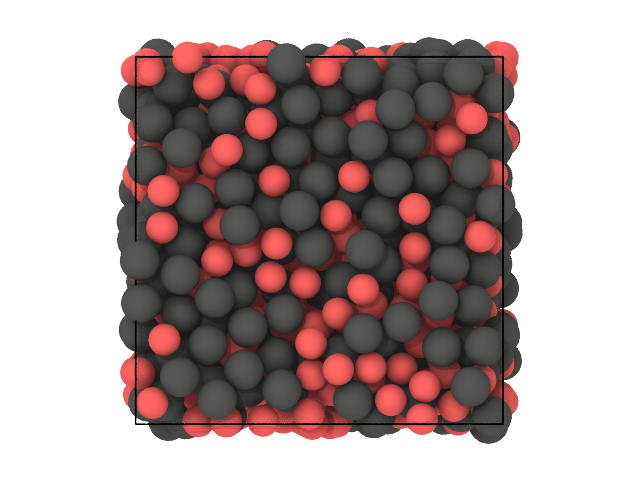

In [26]:
# First snapshot: species
traj[0].show(backend='ovito', color='species')

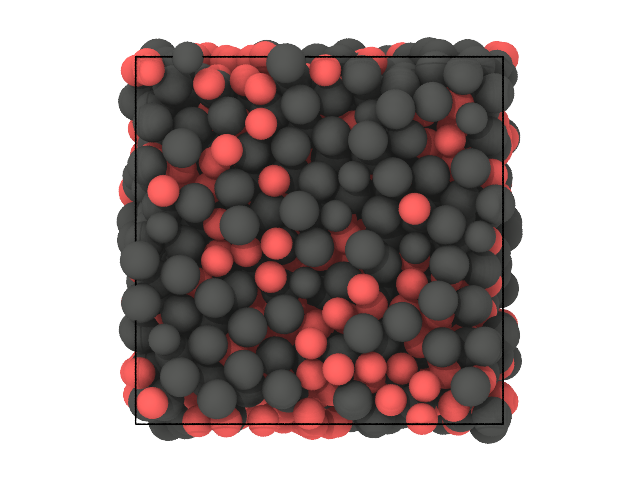

In [27]:
# Second snapshot: labels
traj[0].show(backend='ovito', color='label')

We see that, for the vast majority of the particles, the clustering was able to recover the species solely based on spatial correlation.

<div class="alert alert-info">
    Note
    
    The colors in the second snapshot depend on the execution (labels 0 and 1 can be reversed).
</div>

### With chemical information

Let us now repeat the previous clustering using chemical information. As mentioned before, the species of the particles should be atomic symbols. Let us first change the name of the species labels, say `"A"`→`"C"` and `"B"`→`"H"` :

In [28]:
# Change the name of the species
traj.set_property('species', 'C', "species == 'A'")
traj.set_property('species', 'H', "species == 'B'")

Let us now repeat the clustering using `DscribeChemicalDescriptor`:

In [29]:
from partycls.descriptors import DscribeChemicalDescriptor

# Descriptor
D = DscribeChemicalDescriptor(traj, SOAP, sigma=0.1, rcut=3.0, lmax=7, nmax=7, rbf='gto')

# Workflow
# Z-score + PCA with 2 components (default) + K-Means
wf = Workflow(traj, D, scaling='z-score', 
              dim_reduction='PCA', 
              clustering='K-means')
wf.n_init = 10
wf.run()

This time again, a quick way to visualize the results is to visually compare species and cluster labels:

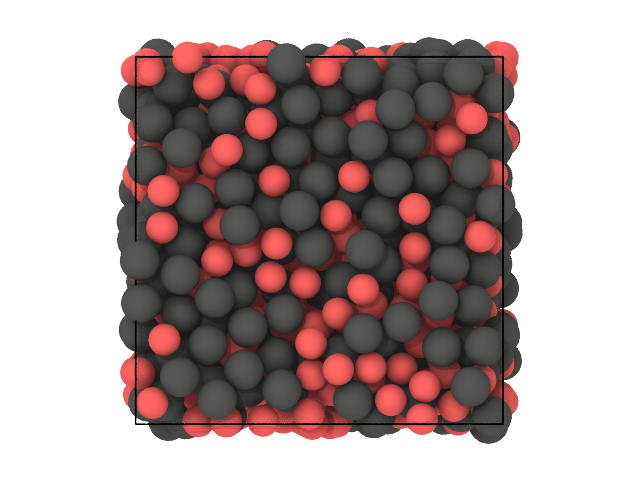

In [30]:
# First snapshot: species
traj[0].show(backend='ovito', color='species')

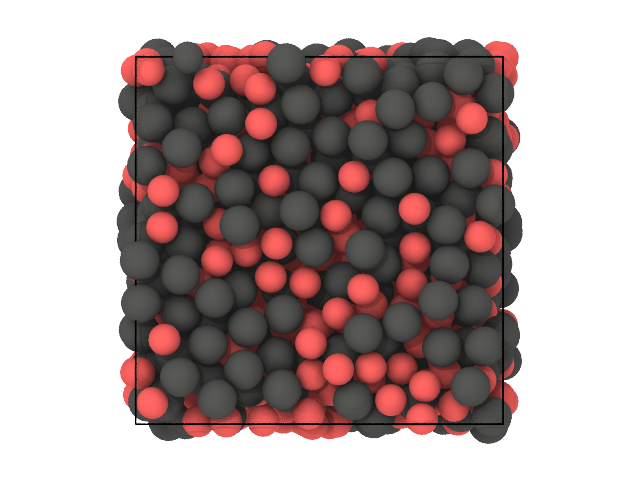

In [31]:
# Second snapshot: labels
traj[0].show(backend='ovito', color='label')

The first clustering was already able to distinguish between the species, so this comes as no surprise that this is still the case here.

<div class="alert alert-info">
    Note

    Like the previous clustering, the colors in the second snapshot depend on the execution (labels 0 and 1 can be reversed).
</div>